Import necessary libraries

In [1]:
import numpy as np
from scipy import stats  
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [2]:
# Load the JSON file into a DataFrame
df = pd.read_json('logins.json')

df.head(20)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
5,1970-01-01 20:21:41
6,1970-01-01 20:12:16
7,1970-01-01 20:35:47
8,1970-01-01 20:35:38
9,1970-01-01 20:47:52


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


Looks like the json file is a single column of login times. Size is 727.8 Kb and is in date-time

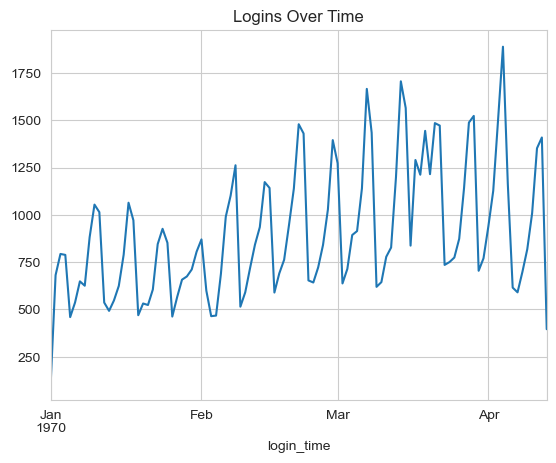

In [4]:
# Plot the login count over time
df.set_index('login_time', inplace=True)
df.resample('D').size().plot()  # Daily login counts
plt.title('Logins Over Time')
plt.show()

Appears logins have increased over time and are cyclical, likely over the course of the week. 

## Resample to 15-minute Intervals

### Resample and add additional features

1. **Resampling Logins**: Data is resampled into 15-minute intervals and login counts are calculated.
2. **Feature Extraction**: New columns for day of the week and hour of the day are created.

In [5]:
# Resample data into 15-minute intervals and count logins
df_resampled = df.resample('15min').size().reset_index(name='login_counts')

# Extract time-related features: day of the week, hour
df_resampled['day_of_week'] = df_resampled['login_time'].dt.day_name()
df_resampled['hour'] = df_resampled['login_time'].dt.hour

In [6]:
df_resampled.head(10)

,login_time,login_counts,day_of_week,hour
0,1970-01-01 20:00:00,2,Thursday,20
1,1970-01-01 20:15:00,6,Thursday,20
2,1970-01-01 20:30:00,9,Thursday,20
3,1970-01-01 20:45:00,7,Thursday,20
4,1970-01-01 21:00:00,1,Thursday,21
5,1970-01-01 21:15:00,4,Thursday,21
6,1970-01-01 21:30:00,0,Thursday,21
7,1970-01-01 21:45:00,4,Thursday,21
8,1970-01-01 22:00:00,9,Thursday,22
9,1970-01-01 22:15:00,8,Thursday,22


In [7]:
# Summary statistics for login counts
df_resampled.describe()

,login_time,login_counts,hour
count,9788,9788.000000,9788.000000
mean,1970-02-21 19:22:29.999999999,9.515938,11.496935
min,1970-01-01 20:00:00,0.000000,0.000000
25%,1970-01-27 07:41:15,3.000000,5.000000
50%,1970-02-21 19:22:30,7.000000,11.000000
75%,1970-03-19 07:03:45,13.000000,17.000000
max,1970-04-13 18:45:00,73.000000,23.000000
std,NaN,8.328818,6.922294


The time period covered is from Jan-01 1970 up to Apri-13 1970

In [8]:
# Check for missing values
print(df_resampled.isnull().sum())

login_time      0
login_counts    0
day_of_week     0
hour            0
dtype: int64


No missing values

## Login Counts over Time

Plot login counts over time alongside weekly and daily moving averages.

### Observations:
1. Login counts clearly show cyclic behaviour on a weekly basis.
2. Login counts have generally increased since the beginning of the time period

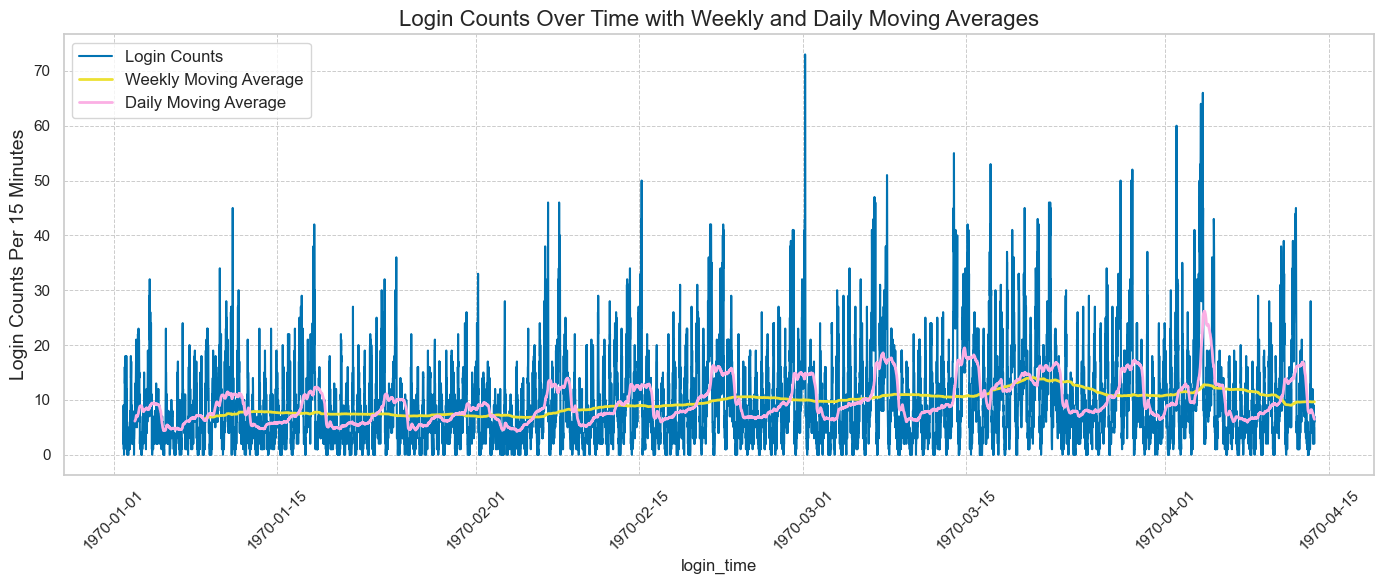

In [9]:
# Calculate weekly and daily moving averages for login counts
df_resampled['weekly_moving_avg'] = df_resampled['login_counts'].rolling(window=7*24*4).mean()  # Weekly (7 days)
df_resampled['daily_moving_avg'] = df_resampled['login_counts'].rolling(window=24*4).mean()     # Daily (1 day)

# Set Seaborn style and color palette for colorblind-friendly plots
sns.set(style='whitegrid', palette='colorblind')

# Plot login counts, weekly and daily moving averages
plt.figure(figsize=(14, 6))

sns.lineplot(x='login_time', y='login_counts', data=df_resampled, color=sns.color_palette('colorblind')[0], label='Login Counts')
sns.lineplot(x='login_time', y='weekly_moving_avg', data=df_resampled, color=sns.color_palette('colorblind')[8], label='Weekly Moving Average', linewidth=2)
sns.lineplot(x='login_time', y='daily_moving_avg', data=df_resampled, color=sns.color_palette('colorblind')[6], label='Daily Moving Average', linewidth=2)

# Customize plot: title, labels, legend, and grid
plt.title('Login Counts Over Time with Weekly and Daily Moving Averages', fontsize=16)
plt.ylabel('Login Counts Per 15 Minutes', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.7)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

## Seasonal Decomposition

Perform a seasonal decomposition of login counts over time, breaking down the time series into its observed, trend, seasonal, and residual components.

1. **Seasonal Decomposition**: The `seasonal_decompose` function is used with an additive model, specifying a period that corresponds to one week (672 observations, given 15-minute intervals).

2. **Plotting Components**: Four subplots are created to visualize:
   - **Observed Login Counts**: Displays the actual login counts.
   - **Trend**: Shows the underlying trend over a week.
   - **Seasonal Component**: Captures repeating patterns within the week.
   - **Residuals**: Represents the noise remaining after removing the trend and seasonal components.

### Observations:
1. 7 day trend shows general increase from the beginning of the time interval, however a peak around mid March. 
2. Seasonal shows daily variation around the trend line in a very repetiive manner. 
3. The residuals appear to be randomly distributed around zero, suggesting that our model adequately captures the underlying patterns in the login counts.

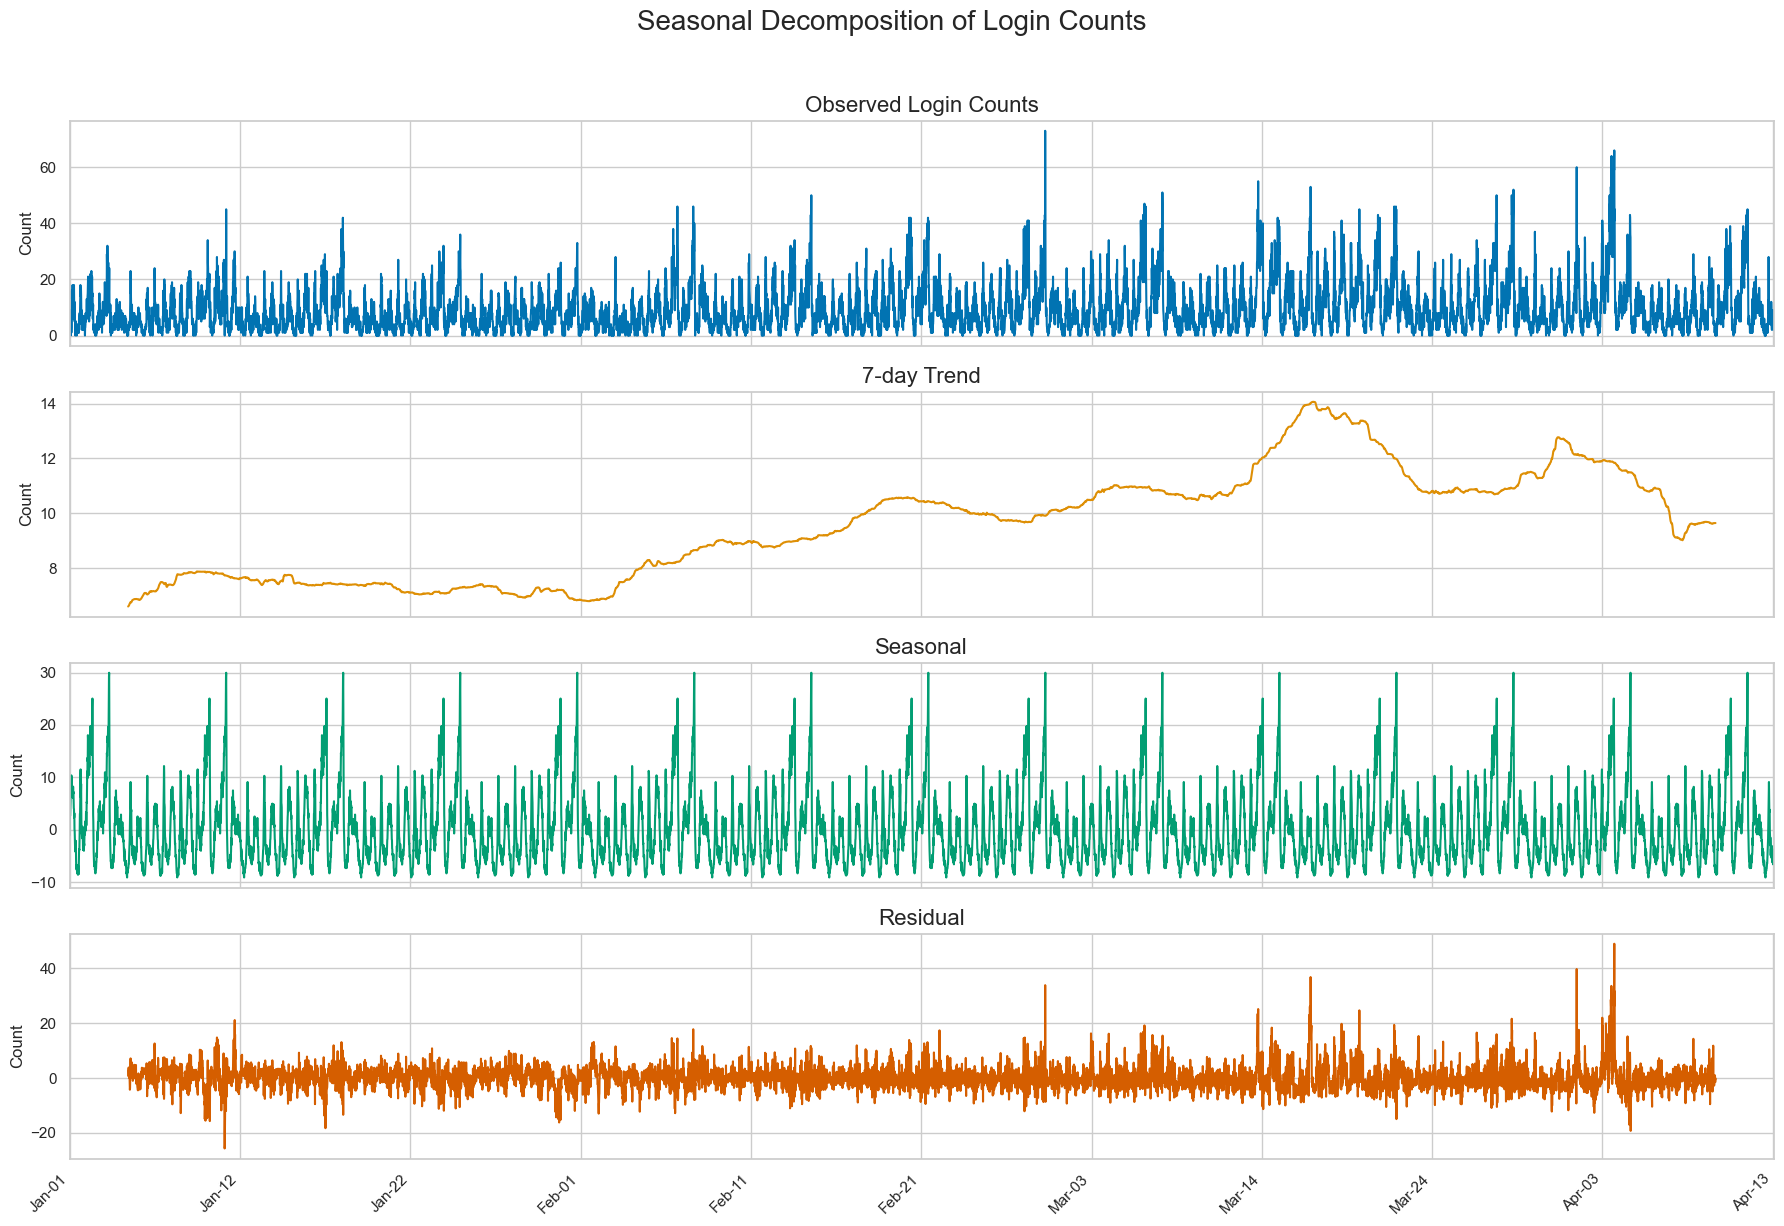

In [10]:
# Set a colorblind-friendly palette
cb_palette = sns.color_palette("colorblind")

# Decompose the 'login_counts' time series using an additive model and a weekly seasonal period
result = seasonal_decompose(df_resampled['login_counts'], model='additive', period=7 * 24 * 4)  # 672 observations for a week

# Create a figure with 4 subplots, sharing the x-axis
fig, axs = plt.subplots(4, 1, figsize=(18, 12), sharex=True)

# Plot observed login counts
axs[0].plot(df_resampled['login_time'], result.observed, color=cb_palette[0])
axs[0].set_title('Observed Login Counts', fontsize=16)
axs[0].set_ylabel('Count', fontsize=12)
axs[0].grid(True)

# Plot the 7-day trend
axs[1].plot(df_resampled['login_time'], result.trend, color=cb_palette[1])
axs[1].set_title('7-day Trend', fontsize=16)
axs[1].set_ylabel('Count', fontsize=12)
axs[1].grid(True)

# Plot seasonal components
axs[2].plot(df_resampled['login_time'], result.seasonal, color=cb_palette[2])
axs[2].set_title('Seasonal', fontsize=16)
axs[2].set_ylabel('Count', fontsize=12)
axs[2].grid(True)

# Plot residuals
axs[3].plot(df_resampled['login_time'], result.resid, color=cb_palette[3])
axs[3].set_title('Residual', fontsize=16)
axs[3].set_ylabel('Count', fontsize=12)
axs[3].grid(True)

# Format x-axis for datetime display
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Rotate x-axis labels for better readability
plt.setp(axs[3].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Set x-axis limits based on the data range
axs[3].set_xlim(df_resampled['login_time'].min(), df_resampled['login_time'].max())

# Automatically adjust x-ticks based on login_time
tick_indices = df_resampled['login_time'][::max(1, len(df_resampled) // 10)]  # Every N-th index
axs[3].set_xticks(tick_indices)

# Set formatted tick labels for better readability
axs[3].set_xticklabels([tick.strftime('%b-%d') for tick in tick_indices], rotation=45)

# Add a main title for the entire figure
plt.suptitle('Seasonal Decomposition of Login Counts', fontsize=20, y=1.02)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Anomaly Detection in Login Counts

This code snippet identifies and visualizes anomalies in login counts based on a statistical approach. It filters the data to find points where login counts exceed the threshold of the mean plus two standard deviations. 

### Observations: 
1. Outliers are deteceted however not with enough evidence to support removing datapoints

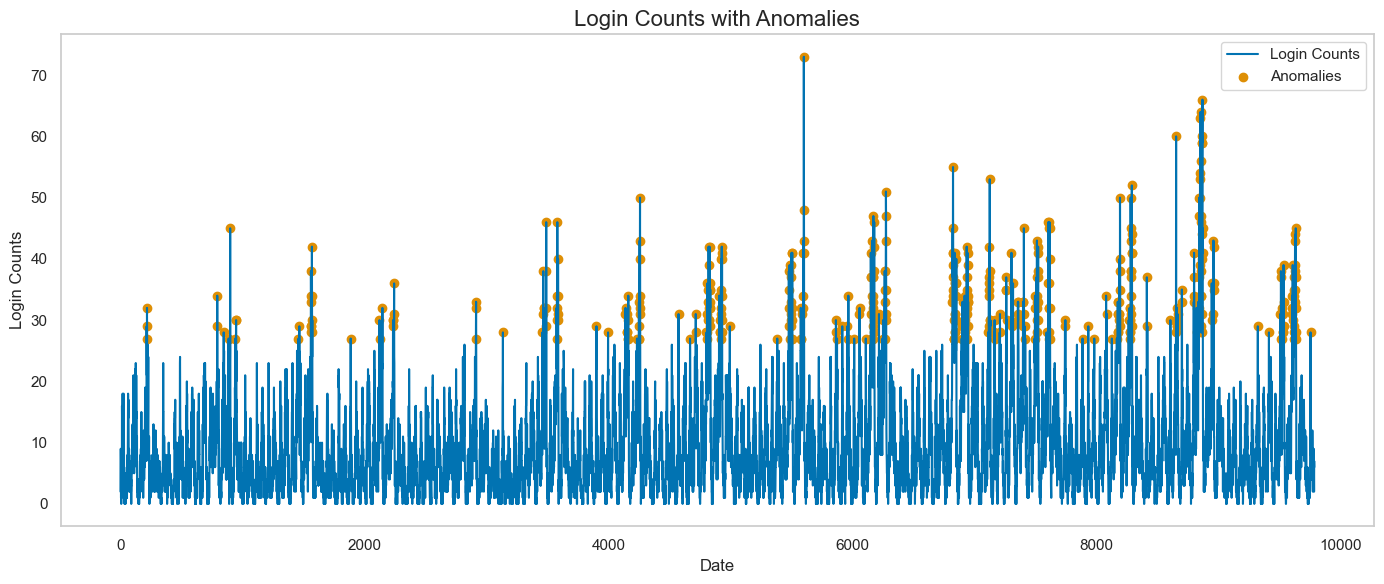

In [11]:
# Filter the DataFrame for anomalies: counts above mean + 2 standard deviations
anomalies = df_resampled[df_resampled['login_counts'] > df_resampled['login_counts'].mean() + 2 * df_resampled['login_counts'].std()]

# Set colorblind-friendly palette using Seaborn
cb_palette = sns.color_palette("colorblind")

# Create a figure for the plot with specified dimensions
plt.figure(figsize=(14, 6))

# Plot login counts over time
plt.plot(df_resampled['login_counts'], label='Login Counts', color=cb_palette[0])  

# Plot detected anomalies as scatter points
plt.scatter(anomalies.index, anomalies['login_counts'], color=cb_palette[1], label='Anomalies')  

# Set plot title and labels
plt.title('Login Counts with Anomalies', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Login Counts', fontsize=12)

# Add legend and grid for clarity
plt.legend()
plt.grid()

# Adjust layout to enhance visual clarity
plt.tight_layout()

# Display the plot
plt.show()

## Distribution of Login Counts

Visualize the distribution of login counts using a histogram combined with a Kernel Density Estimate (KDE) for smoothness. The histogram displays the frequency of login counts across specified bins, providing insight into the overall distribution.

A normal distribution curve is overlaid on the histogram to illustrate how the login counts compare to a standard normal distribution. The mean and standard deviation of the login counts are calculated to generate the normal distribution, allowing for a visual assessment of how closely the data adheres to normality.

### Observations:
1. Our KDE starts at 0 and goes up around 3 login counts, then decreases to ~0 by 50 logincounts. Therefore it is right skewed. 
2. Our data is not normally distributed. 

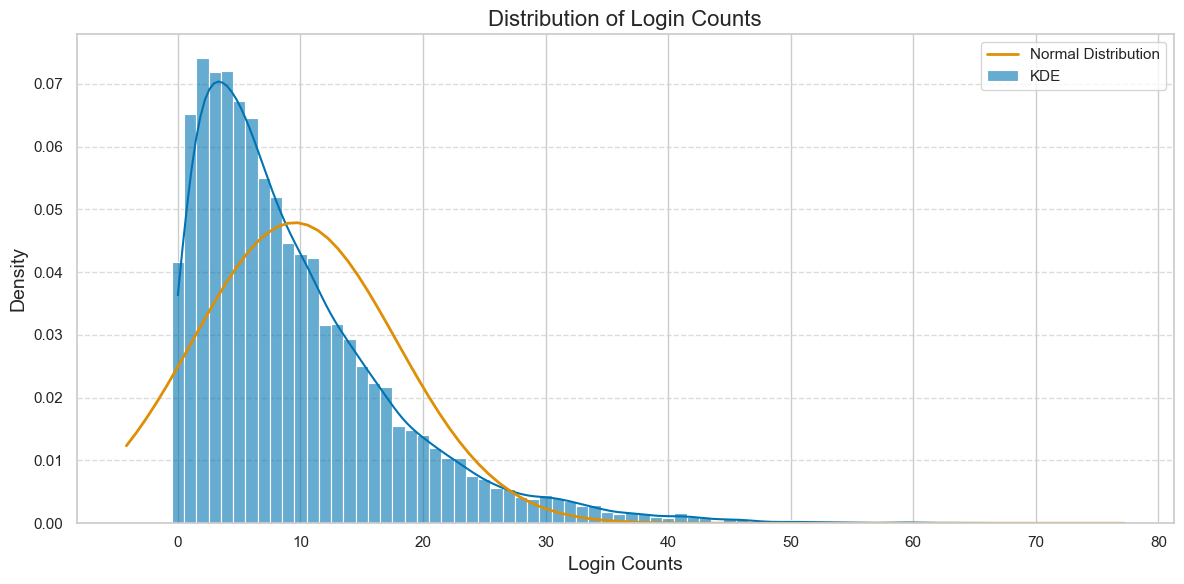

In [12]:
# Plot the distribution of login counts
plt.figure(figsize=(12, 6))

# Create histogram with KDE overlay
sns.histplot(df_resampled['login_counts'], bins=100, kde=True, 
             color=sns.color_palette("colorblind")[0], stat='density', 
             alpha=0.6, label='KDE', discrete=True)

# Calculate mean and standard deviation for normal distribution
mean = df_resampled['login_counts'].mean()
std_dev = df_resampled['login_counts'].std()

# Generate points for normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std_dev)

# Plot the normal distribution curve
plt.plot(x, p, linewidth=2, color=sns.color_palette("colorblind")[1], label='Normal Distribution')

# Set plot title and labels
plt.title('Distribution of Login Counts', fontsize=16)
plt.xlabel('Login Counts', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Add grid and legend for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()

## Average Logins by Day of the Week

This analysis visualizes login activity throughout the week using two bar plots. The first plot shows the average number of logins in 15-minute intervals. The second plot represents the average total logins per day, summarizing user activity trends over the week.

### Observations:
1. Monday has the lowest logins per day on average, then increases to Saturday which has the most. Sunday has the second highest average logins. 
2. Monday has ~600 logins per day while Saturday has ~1300.

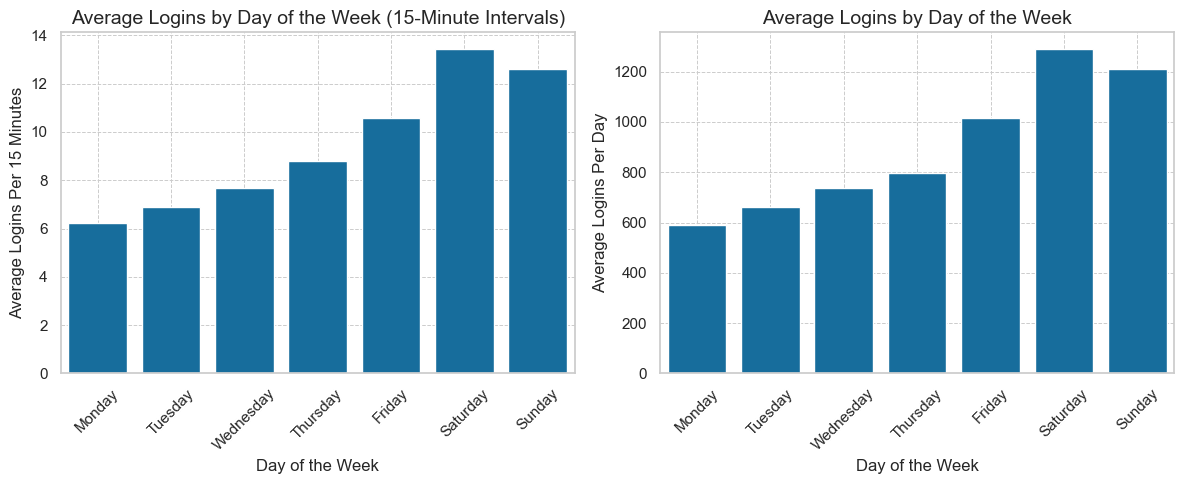

In [13]:
# Set the seaborn color palette for colorblind-friendly colors
sns.set_palette("colorblind")

# Calculate average logins per 15-minute interval by day of the week
avg_logins_by_15min = (
    df_resampled
    .groupby('day_of_week')['login_counts']
    .mean()
    .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
)

# Group by date to get total logins for each day
df_resampled['date'] = df_resampled['login_time'].dt.date
daily_logins = (
    df_resampled
    .groupby('date')['login_counts']
    .sum()
    .reset_index()
)
daily_logins['day_of_week'] = pd.to_datetime(daily_logins['date']).dt.day_name()

# Calculate average total logins by day of the week
avg_logins_by_day = (
    daily_logins
    .groupby('day_of_week')['login_counts']
    .mean()
    .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
)

# Create subplots for the two visualizations
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Left plot: Average logins by day of the week (15-minute intervals)
sns.barplot(x=avg_logins_by_15min.index, y=avg_logins_by_15min.values, ax=axes[0])
axes[0].set_title('Average Logins by Day of the Week (15-Minute Intervals)', fontsize=14)
axes[0].set_xlabel('Day of the Week', fontsize=12)
axes[0].set_ylabel('Average Logins Per 15 Minutes', fontsize=12)
axes[0].set_xticks(range(len(avg_logins_by_15min.index)))  # Set x-ticks
axes[0].set_xticklabels(avg_logins_by_15min.index, rotation=45)
axes[0].grid(visible=True, linestyle='--', linewidth=0.7)  # Dotted line grid

# Right plot: Average total logins by day of the week
sns.barplot(x=avg_logins_by_day.index, y=avg_logins_by_day.values, ax=axes[1])
axes[1].set_title('Average Logins by Day of the Week', fontsize=14)
axes[1].set_xlabel('Day of the Week', fontsize=12)
axes[1].set_ylabel('Average Logins Per Day', fontsize=12)
axes[1].set_xticks(range(len(avg_logins_by_day.index)))  # Set x-ticks
axes[1].set_xticklabels(avg_logins_by_day.index, rotation=45)
axes[1].grid(visible=True, linestyle='--', linewidth=0.7)  # Dotted line grid

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Average Logins per Hour

This section visualizes login activity on an hourly basis using two types of plots. 

1. **Average Logins per Hour**: The first subplot shows the average number of logins for each hour of the day. 

2. **Distribution of Logins per Hour**: The second subplot is a box-and-whisker plot that illustrates the distribution of logins for each hour. This visualization helps to identify the spread and outliers in login counts, providing deeper insights into user behavior throughout the day.

### Observations:
- Peaks in average logins occur arround 11am and between 10pm-1am. 
- The box plot gives further insight into the quartiles and outliers. We clearly see minimum logins around 7 and 8am. 

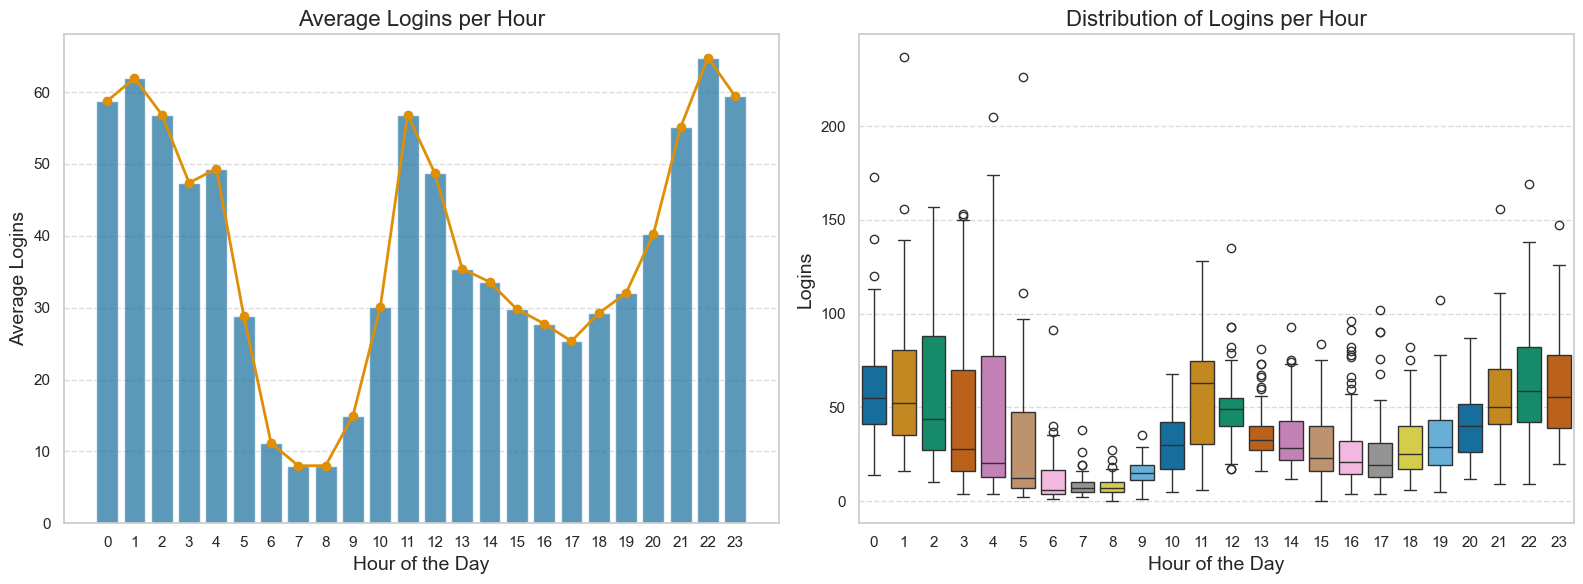

In [14]:
# Group by day and hour, summing the logins
hourly_logins = df_resampled.groupby([df_resampled['login_time'].dt.date, 'hour'])['login_counts'].sum().reset_index()

# Calculate average logins per hour
average_hourly_logins = hourly_logins.groupby('hour')['login_counts'].mean().reset_index(name='average_logins')

# Setting Seaborn style
sns.set(style="whitegrid")

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plotting Average Logins per Hour
sns.barplot(x='hour', y='average_logins', 
            data=average_hourly_logins, 
            color=sns.color_palette("colorblind")[0], 
            alpha=0.7, ax=axes[0])

# Overlaying the line plot for averages
axes[0].plot(average_hourly_logins['hour'], 
             average_hourly_logins['average_logins'], 
             marker='o', 
             color=sns.color_palette("colorblind")[1], 
             linewidth=2)

# Titles and labels for average logins
axes[0].set_title('Average Logins per Hour', fontsize=16)
axes[0].set_xlabel('Hour of the Day', fontsize=14)
axes[0].set_ylabel('Average Logins', fontsize=14)
axes[0].set_xticks(average_hourly_logins['hour'])
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Box and Whisker Plot for Logins per Hour
sns.boxplot(x='hour', y='login_counts', data=hourly_logins, 
            palette="colorblind", ax=axes[1], hue='hour', dodge=False, legend=False)

# Titles and labels for box plot
axes[1].set_title('Distribution of Logins per Hour', fontsize=16)
axes[1].set_xlabel('Hour of the Day', fontsize=14)
axes[1].set_ylabel('Logins', fontsize=14)
axes[1].set_xticks(range(24))
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

## Total Logins by Day of the Week vs Hour Heatmap

Visualize the total logins by day of the week and hour of the day using a heatmap. The heatmap provides insights into login patterns, showing how user activity varies across different days and times.

### Observations:
1. Friday night / Saturday early morning along with Saturday night / Sunday early morning have the highest logins. 
2. Many more logins during the weekend compared to other days

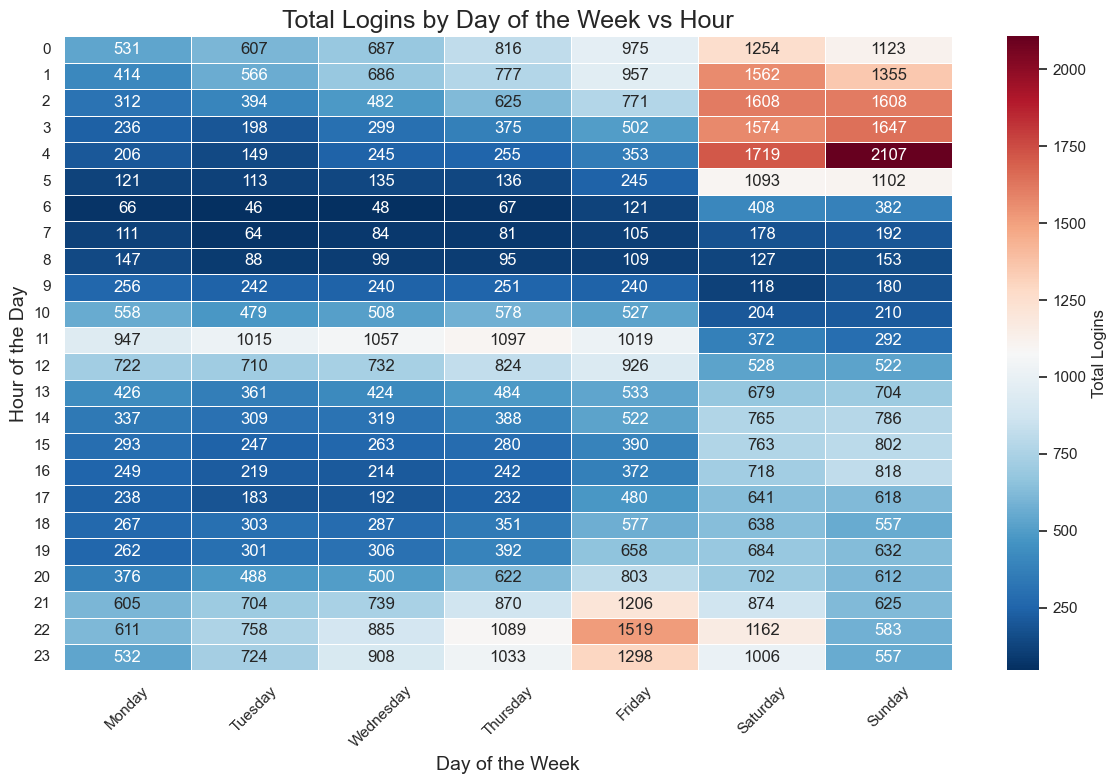

In [15]:
# Extract the day of the week from login_time
df_resampled['day_of_week'] = df_resampled['login_time'].dt.day_name()

# Group by day of the week and hour, then sum the login counts
total_logins_by_hour_day = (df_resampled
                             .groupby(['day_of_week', 'hour'])['login_counts']
                             .sum()
                             .reset_index())

# Pivot the data to create a matrix for the heatmap
heatmap_data = (total_logins_by_hour_day
                 .pivot(index='hour', columns='day_of_week', values='login_counts'))

# Sort the days of the week to maintain the order
heatmap_data = heatmap_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

# Setting Seaborn style
sns.set(style="whitegrid")

# Create the heatmap with a colorblind-friendly red and blue palette
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap=sns.color_palette("RdBu_r", as_cmap=True), 
            annot=True, fmt=".0f", linewidths=0.5, 
            cbar_kws={'label': 'Total Logins'})

# Titles and labels for the heatmap
plt.title('Total Logins by Day of the Week vs Hour', fontsize=18)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Hour of the Day', fontsize=14)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.yticks(rotation=0)    # Keep y-axis labels horizontal

plt.tight_layout()  
plt.show()

## Normalized Total Logins by Week vs Hour Heatmap

This section visualizes the normalized total logins by week number and hour of the day using a heatmap. The heatmap illustrates how login patterns change throughout the weeks and across different hours.

### Observations: 
1. From left to right on a given hour we see that the % of daily login that occurs that day does not really change, maybe basline +/- 1%
2. Slow hours tended to remain slow, high login hours tended to remain high login as time went on

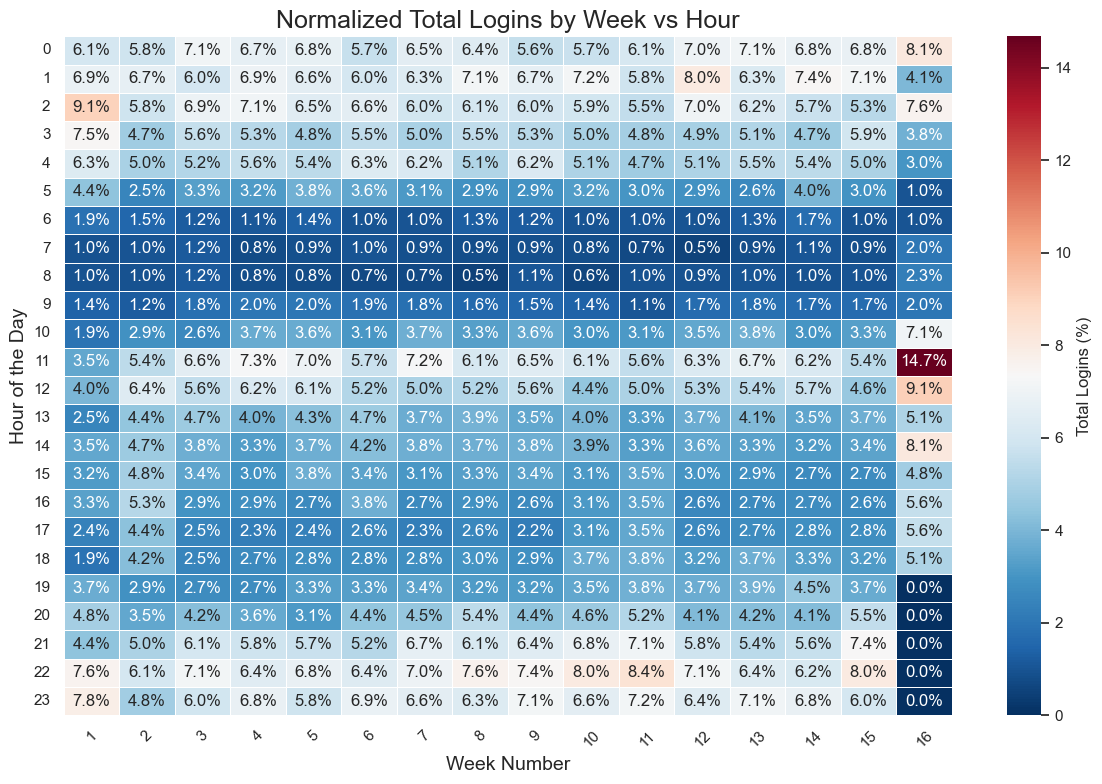

In [16]:
# Extract the week number from login_time
df_resampled['week'] = df_resampled['login_time'].dt.isocalendar().week

# Group by week number and hour, then sum the login counts
total_logins_by_hour_week = (df_resampled
                              .groupby(['week', 'hour'])['login_counts']
                              .sum()
                              .reset_index())

# Normalize the logins by week
total_logins_per_week = (total_logins_by_hour_week
                         .groupby('week')['login_counts']
                         .transform('sum'))
total_logins_by_hour_week['normalized_logins'] = (total_logins_by_hour_week['login_counts'] 
                                                  / total_logins_per_week)

# Convert normalized logins to percentage
total_logins_by_hour_week['percentage_logins'] = total_logins_by_hour_week['normalized_logins'] * 100

# Pivot the data to create a matrix for the heatmap
heatmap_data = (total_logins_by_hour_week
                 .pivot(index='hour', columns='week', values='percentage_logins')
                 .fillna(0))  # Fill NaN values with 0 for better display

# Setting Seaborn style
sns.set(style="whitegrid")

# Create the heatmap with a colorblind-friendly red and blue palette
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap=sns.color_palette("RdBu_r", as_cmap=True), 
            annot=heatmap_data.round(1).astype(str) + '%', fmt='', 
            linewidths=0.5, cbar_kws={'label': 'Total Logins (%)'})

# Titles and labels for the heatmap
plt.title('Normalized Total Logins by Week vs Hour', fontsize=18)
plt.xlabel('Week Number', fontsize=14)
plt.ylabel('Hour of the Day', fontsize=14)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.yticks(rotation=0)    # Keep y-axis labels horizontal

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()